# Data Analytics - ML25M 

### Imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import torch


## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [70]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_df.drop('genres', axis=1, inplace=True)

movies_df.head(3)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [71]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
# round ratings to the nearest 0.5
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: round(x * 2) / 2)

df = ratings_df.merge(df, on='movieId')

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

## Data visualization

In [72]:
df.head(3)

,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,4.0,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,3.5,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975
2,3.0,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.023,0.12200,0.03475,0.017,0.01800,0.09100,0.01775


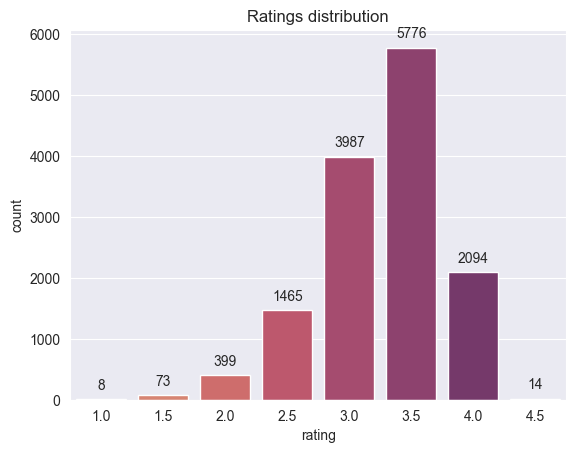

In [73]:
# Ratings distribution
sns.countplot(x='rating', data=df, palette='flare')
plt.title('Ratings distribution')
for p in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

## Data Preprocessing

In [74]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# cast to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

## Modeling

### Traditional ML

In [77]:
# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=50,
                                bootstrap = True,
                                max_features = 'sqrt')
# Fit on training data
model.fit(X_train, Y_train)

# accuracy
print('Accuracy:', model.score(X_test, Y_test))

Accuracy: 0.851392418502484


### Neural Network

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: MSELoss.forward() got an unexpected keyword argument 'reduction'

### Deep Learning for Tabular Data

## Evaluation